# Transformadores para la generación de Texto plano - IBM PROYECTO DE ENTREGA

## Objetivos:

- Implementar Transformers para tareas de generación de texto

- Construir, entrenar y evaluar modelos de Transformers para la generación de texto con TensorFlow y Keras

- Aplicar la generación de texto en situaciones reales

----


### Instrucciones paso a paso

#### Paso 1: Configurar el entorno

- Importar las bibliotecas necesarias y cargar el conjunto de datos

- Preprocesar el conjunto de datos para el entrenamiento

En el siguiente código:

- Importar TensorFlow y otras bibliotecas necesarias.

- Cargar el conjunto de datos de texto de Shakespeare.

- Preprocesar el conjunto de datos utilizando la capa TextVectorization para convertir el texto en secuencias de enteros.


In [12]:
%%capture
!pip install tensorflow==2.16.2
!pip install pandas
!pip install scikit-learn

In [13]:
import tensorflow as tf 
import numpy as np 
from tensorflow.keras.layers import TextVectorization 
from tensorflow.keras.utils import get_file 

In [14]:
# Load the dataset 
path_to_file = get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt') 
text = open(path_to_file, 'rb').read().decode(encoding='utf-8') 

# Preview the dataset 
print(text[:1000]) 

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [15]:
# Preprocess the dataset 
vocab_size = 10000 
seq_length = 100 

# Adapt TextVectorization to full text 
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int') 
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1) 
vectorizer.adapt(text_ds) 

# Vectorize the text 
vectorized_text = vectorizer([text])[0] 
print("Vectorized text shape:", vectorized_text.shape) 
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10]) 

Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]


#### Paso 2: Crear secuencias de entrada y destino

Generar secuencias de entrada y destino para entrenar el modelo Transformer.

En el siguiente código:

- Definir una función para generar secuencias de entrada y destino.

- Dividir los datos de texto en secuencias de la longitud especificada.

- Convertir las secuencias en tensores de TensorFlow para el entrenamiento.

Secuencia generativa:


In [16]:
def create_sequences(text, seq_length): 
    input_seqs = [] 
    target_seqs = [] 
    for i in range(len(text) - seq_length): 
        input_seq = text[i:i + seq_length] 
        target_seq = text[i + 1:i + seq_length + 1] 
        input_seqs.append(input_seq) 
        target_seqs.append(target_seq) 
    return np.array(input_seqs), np.array(target_seqs) 

# Generate sequences 
X, Y = create_sequences(vectorized_text.numpy(), seq_length) 

# Check if sequences are correctly generated 
print("Number of sequences generated:", len(X)) 
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated") 

# Check if X and Y are not empty 
assert X.size > 0, "Input data X is empty" 
assert Y.size > 0, "Target data Y is empty" 
X = tf.convert_to_tensor(X) 
Y = tf.convert_to_tensor(Y) 
print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape)


Number of sequences generated: 202546
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79  506   27    3   56   24 1390
   57   40  161 2328  644    9 4980   34   32   54 2863  885   72   17
   18  163  146  146  165  270   74  218   46  595   89  270   36   41
 6739  172  595    2 1780   46   29 1323 5151   47   58 4151   79   39
   60   58]
Shape of X: (202546, 100)
Shape of Y: (202546, 100)


### Paso 3: Construir el modelo Transformer

Defina la arquitectura del modelo Transformer para la generación de texto.

En el siguiente código:

- Defina la clase TransformerBlock, que incluye capas de atención multicabezal y de avance con normalización y abandono.

- Defina la clase TransformerModel, que incluye incrustación, codificación posicional y múltiples bloques Transformer.

- Compile el modelo Transformer utilizando el optimizador Adam y la función de pérdida de entropía cruzada categórica dispersa.

Modelo Transformer:

In [17]:
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(Model):  # Model is now properly imported
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.dense = Dense(vocab_size)

    def positional_encoding(self, seq_length, embed_dim):
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :seq_len, :]
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)  # Pass training argument correctly
        output = self.dense(x)
        return output

In [18]:
# Hyperparameters 
embed_dim = 256 
num_heads = 4 
ff_dim = 512 
num_layers = 4 

# Build the Transformer model 
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

# Compile the model 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Summary of the model 
model.summary()


Model: "transformer_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 100, 256)               │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_4                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_5                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_6                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_7                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (1, 100, 10000)             │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,393,360 (39.65 MB)

 Trainable params: 10,393,360 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

#### Paso 4: Entrenar el modelo Transformer

Entrenar el modelo Transformer con los datos de texto preprocesados.

En el siguiente código:

- Entrenar el modelo Transformer con las secuencias de entrada y destino.

- Graficar la pérdida de entrenamiento para monitorizar el rendimiento del modelo a lo largo de las épocas.

Entrenamiento del modelo:


In [19]:
!pip install matplotlib

> #### Nota: El conjunto de datos original es grande, lo hemos reducido a 10 000 muestras y hemos limitado el entrenamiento a 2 épocas para minimizar el tiempo de ejecución.

In [20]:
X = X[:10000]
Y = Y[:10000]

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 783s 2s/step - loss: 10.7832
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 785s 3s/step - loss: 10.9484


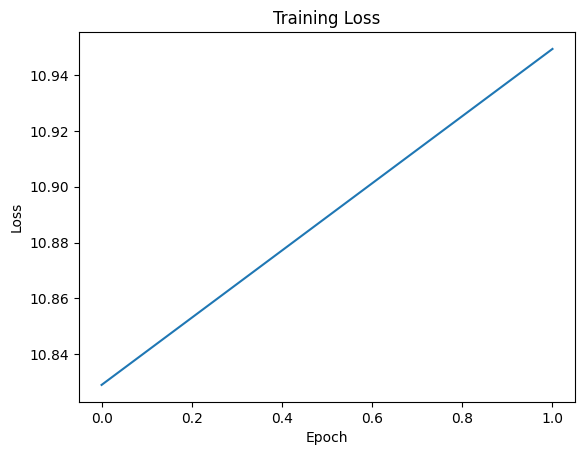

In [21]:
# Import necessary libraries for training visualization
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on the full input and target sequences
history = model.fit(X, Y, epochs=2, batch_size=32, callbacks=[early_stopping])

# Plot training loss to monitor model performance over epochs
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


#### Paso 5: Generar texto con el modelo entrenado

Defina una función para generar texto usando el modelo Transformer entrenado.

En el siguiente código:

- Defina la función generate_text para generar texto usando el modelo Transformer entrenado.

- Convierta la cadena inicial a formato numérico.

- Use el modelo para predecir la siguiente palabra y añadirla al texto generado.

- Imprima el texto generado.

#### Generación de texto:

In [22]:
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    # Convert the start string to a vectorized format
    input_eval = vectorizer([start_string]).numpy()
    
    # Ensure the input length is the same as the model's expected input shape
    if input_eval.shape[1] < seq_length:
        # Pad the input if it's shorter than the expected sequence length
        padding = np.zeros((1, seq_length - input_eval.shape[1]))
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
        # Truncate the input if it's longer than the expected sequence length
        input_eval = input_eval[:, -seq_length:]

    input_eval = tf.convert_to_tensor(input_eval)
    
    # Initialize an empty list to store generated text
    text_generated = []

    # Start generating text
    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)

        # Remove only the batch dimension, keep the logits as 2D (batch_size, vocab_size)
        predictions = predictions[0]  # This should be of shape [vocab_size]

        # Apply temperature to predictions
        predictions = predictions / temperature
        
        # Use a categorical distribution to predict the next word
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)  # Append predicted token
        input_eval = input_eval[:, -seq_length:]  # Keep only the last `seq_length` tokens
        input_eval = tf.convert_to_tensor(input_eval)  # Convert back to tensor

        # Append the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    # Return the generated text starting from the initial seed
    return start_string + ' ' + ' '.join(text_generated)

# Generate text with temperature control
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string, temperature=0.7)  # Lower temperature for more focused predictions
print(generated_text)


To be, or not to be time strewed pull volumnia body [UNK] osprey volumnia first why mans arrive at birthright his wherefore betrayd sweets justifyt dreamd snowbroth island my sewing who who knaves general volumnia oil beggar discern lewis who their you weeping corioli noble men sir pray resident volumnia these volumnia dine general sob ripen gods born sayt courts that sped hereafter noble let as that romeo welshmen fashions volumnia napes volumnia these camest rover thus instructions seniory seald loved truedisposing general ale scandal yellows bitterly beetle who palefaced images why been called sop tenth plucked martino likend why charge destroyd enters temperately battles volumnia


### Ejercicios prácticos

> #### Nota: Los resultados pueden variar debido a que se redujo el tamaño del conjunto de datos y el entrenamiento se limitó a 2 épocas para acortar el tiempo de ejecución. Sin embargo, se recomienda experimentar con diferentes valores de época para un aprendizaje más profundo.

### Ejercicio 1: Experimentar con diferentes longitudes de secuencia

**Objetivo:** Implementar diferentes longitudes de secuencia para comprender su efecto en el rendimiento del modelo Transformer.

**Instrucciones:**

- Cambiar la longitud de la secuencia a 50

- Preprocesar el conjunto de datos con la nueva longitud de secuencia

- Entrenar el modelo y comparar la pérdida de entrenamiento

Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]
Number of sequences generated: 202596
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79]
Shape of X: (202596, 50)
Shape of Y: (202596, 50)


Model: "transformer_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, 50, 256)                │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_8                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_9                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_10                 │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_11                 │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (1, 50, 10000)              │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,393,360 (39.65 MB)

 Trainable params: 10,393,360 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - loss: 12.2583
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - loss: 12.3487


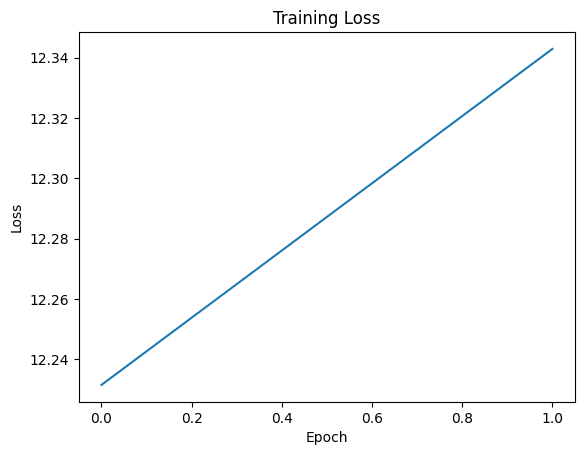

In [23]:
# Preprocess the dataset 
vocab_size = 10000 
seq_length = 50 

# Adapt TextVectorization to full text 
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int') 
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1) 
vectorizer.adapt(text_ds) 

# Vectorize the text 
vectorized_text = vectorizer([text])[0] 
print("Vectorized text shape:", vectorized_text.shape) 
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10]) 

X, Y = create_sequences(vectorized_text.numpy(), seq_length) 


# Check if sequences are correctly generated 
print("Number of sequences generated:", len(X)) 
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated") 

# Check if X and Y are not empty 
assert X.size > 0, "Input data X is empty" 
assert Y.size > 0, "Target data Y is empty" 
X = tf.convert_to_tensor(X) 
Y = tf.convert_to_tensor(Y) 
print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape)
X = X[:10000]
Y = Y[:10000]
# Hyperparameters 
embed_dim = 256 
num_heads = 4 
ff_dim = 512 
num_layers = 4 

# Build the Transformer model 
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

# Compile the model 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Summary of the model 
model.summary()
# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on the full input and target sequences
history = model.fit(X, Y, epochs=2, batch_size=32, callbacks=[early_stopping])

# Plot training loss to monitor model performance over epochs
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


### Añadimos un programador de aprendizaje

**Objetivo:** Implementar un programador de aprendizaje para ajustar la tasa de aprendizaje durante el entrenamiento.

**Instrucciones:**

- Definir un programador de aprendizaje que reduzca la tasa de aprendizaje a la mitad cada 10 épocas.

- Entrenar el modelo con el programador de aprendizaje y comparar la pérdida de entrenamiento.

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 508s 3s/step - loss: 12.3022 - learning_rate: 0.0010
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - loss: 12.2967 - learning_rate: 0.0010


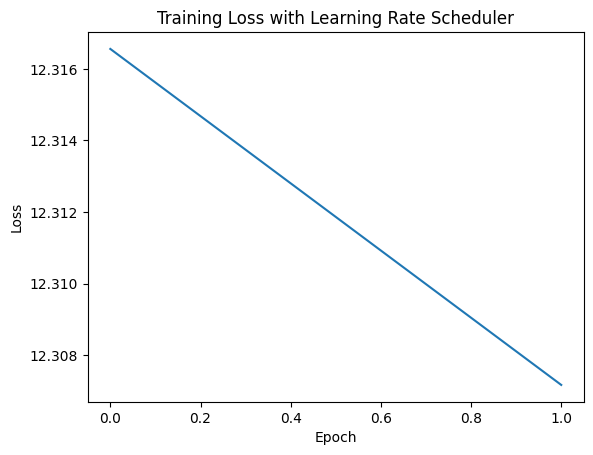

In [24]:
# Write your code here
!pip install pandas
!pip install scikit-learn
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define a learning rate scheduler  
def scheduler(epoch, lr):  
    if epoch % 10 == 0 and epoch != 0:  
        lr = lr * 0.5  
    return lr  
 

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)  


# Train the model with the learning rate scheduler  
history = model.fit(X, Y, epochs=2, batch_size=64, callbacks=[callback])  
   

# Plot the training loss  
plt.plot(history.history['loss'])  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Training Loss with Learning Rate Scheduler')  
plt.show() 


### Ejercicio 3: Generar secuencias de texto más largas

**Objetivo:** Explorar las capacidades de generación de texto del modelo y generar secuencias más largas.

**Instrucciones:**

- Modificar la función `generate_text` para generar 200 tokens en lugar de 100.

- Generar texto utilizando el modelo entrenado y la función modificada.


In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Asegurate de tener definido el modelo y la capa vectorizer antes de ejecutar esta función

def generate_text(model, start_string, num_generate=200):
    # Convertir la cadena inicial en números (vectorizar)
    input_eval = vectorizer([start_string]).numpy()

    # Asegurar que tenga la forma adecuada: (1, secuencia de longitud 5)
    input_eval = tf.convert_to_tensor(input_eval[:, -5:])

    text_generated = []

    for i in range(num_generate):
        # Obtener las predicciones del modelo
        predictions = model(input_eval)  # shape: [1, 5, vocab_size] si devuelve una salida por token

        # Tomar solo la última predicción (del último token de entrada)
        last_prediction = predictions[:, -1, :]  # shape: [1, vocab_size]

        # Seleccionar el siguiente token usando muestreo aleatorio
        predicted_id = tf.random.categorical(last_prediction, num_samples=1)[-1, 0].numpy()

        # Actualizar la secuencia de entrada con el nuevo token
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)
        input_eval = input_eval[:, -5:]  # mantener longitud 5
        input_eval = tf.convert_to_tensor(input_eval)  # reconvertir a tensor

        # Agregar la palabra generada al texto
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    return start_string + ' ' + ' '.join(text_generated)


# Ejemplo de uso (asegurate de tener definidos `model` y `vectorizer`)
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string)

print(generated_text)


To be, or not to be their raze commonwealth posts bear drunken wretches fate stayed dried whereon unwilling traitorous wrangling injury nor woo then musterd nor tumble requireth puffs hoo wreak citizen unwares belly loam caps unsubstantial loath resident ruthful power impiety stray earnestness cushions apprehends where traitor ripest tribute me blots complots sufficient shy third hidden eternal potion handled theatre kisses nor rejoicing from peachcoloured haste had citizen trivial done done prankd tackling boar jay miscarries spire robbing plate plash malice famish their scepterd friendship done satiety windshaken brief caesar territories spire wards nor nor wax close like laidthere then properly temper trencher screen infallible fallen camest monastery mould thunders overthrown staying extremes opprobriously nights nor like judges hallowmas arch nor volume scold manacles willtis nor understand affliction little windows regia matching lows exiled the tasselgentle second career bigger 

#### Conclusión

En el siguiente proyecto se ha creado y entrenado con éxito un modelo Transformer para la generación de texto utilizando TensorFlow y Keras.
Se preprocesar datos de texto, crearon secuencias de entrada y destino, definieron la arquitectura del modelo Transformer, entrenamos el modelo y generar texto utilizando el modelo entrenado. 
Se demostró la experiencia práctica con Transformers para la generación de texto y exploró las aplicaciones prácticas de esta robusta arquitectura de modelo.
